In [118]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/philadelphiacrimedata/crime.csv


In [6]:
from folium.plugins import HeatMap
from folium import plugins
from collections import namedtuple
from shapely.geometry import Point

import geopandas # working with geospatial data in python easier
import folium #visualize spatial data in an interactive manner

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library based on matplotlib
import missingno as msn
import matplotlib.pyplot as plt

<h1><center>City of Philadelphia - Crime Data</center></h1>
<img src="https://www.uwishunu.com/wp-content/uploads/2011/01/east-steps-150dpi-680uw.jpg" widht = 300 height = 500>

# Introduction
This dataset contains crime incidents from the Philadelphia Police Department. Part I crimes include violent offenses such as aggravated assault, rape, arson, among others. Part II crimes include simple assault, prostitution, gambling, fraud, and other non-violent offenses. The dataset previously had separate endpoints for various years and types of incidents. These have since been consolidated into a single dataset.

# Feature Exploration, Engineering and Cleaning
I'll start by first exploring the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

### Loading the data

In [7]:
# acp = All Crime in Philidelphia
acp = pd.read_csv("/Users/samrioboli/Documents/ds320crime/data/crime.csv")
# returns the first 5 parts of the acp dataframe
acp.head() 

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat
0,18,3,2009-10-02 14:24:00,2009-10-02,14:24:00,14,200918067518,S 38TH ST / MARKETUT ST,800.0,Other Assaults,NaN,2009-10,NaN,NaN
1,14,1,2009-05-10 00:55:00,2009-05-10,00:55:00,0,200914033994,8500 BLOCK MITCH,2600.0,All Other Offenses,NaN,2009-05,NaN,NaN
2,25,J,2009-08-07 15:40:00,2009-08-07,15:40:00,15,200925083199,6TH CAMBRIA,800.0,Other Assaults,NaN,2009-08,NaN,NaN
3,35,D,2009-07-19 01:09:00,2009-07-19,01:09:00,1,200935061008,5500 BLOCK N 5TH ST,1500.0,Weapon Violations,20.0,2009-07,-75.130477,40.036389
4,9,R,2009-06-25 00:14:00,2009-06-25,00:14:00,0,200909030511,1800 BLOCK WYLIE ST,2600.0,All Other Offenses,8.0,2009-06,-75.166350,39.969532


## Feature Engineering & Cleaning

In [8]:
# remove all na values from the dataset
# acpc == All Crime Philidelphia Cleaned
acpc = acp.dropna()

# changing dtype police district to int
acpc = acpc.astype({'Police_Districts': 'int64'})

# order based on date
acpc['Dispatch_Date_Time'] = pd.to_datetime(acpc['Dispatch_Date_Time'])
acpc = acpc.sort_values(by='Dispatch_Date_Time', ascending=True)

# creating a seperate list for each year, month and day 
acpc['Year_Nr'] = acpc['Dispatch_Date_Time'].dt.year
acpc['Month_Nr'] = acpc['Dispatch_Date_Time'].dt.month
acpc['Day_Nr'] = acpc['Dispatch_Date_Time'].dt.day

# removing the year 2017 since it's not a complete year
acpc = acpc[acpc.Year_Nr != 2017]

# showing the first 5 rows
acpc.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat,Year_Nr,Month_Nr,Day_Nr
1038493,3,I,2006-01-01 00:00:00,2006-01-01,00:00:00,0,200603000002,S 8TH ST /SOUTH ST,2600.0,All Other Offenses,3,2006-01,-75.155491,39.942416,2006,1,1
1338793,19,R,2006-01-01 00:02:00,2006-01-01,00:02:00,0,200619000047,5500 BLOCK CHERRY ST,800.0,Other Assaults,15,2006-01,-75.231975,39.963220,2006,1,1
1389932,3,I,2006-01-01 00:02:00,2006-01-01,00:02:00,0,200603000001,S 8TH ST /SOUTH ST,2600.0,All Other Offenses,3,2006-01,-75.155491,39.942416,2006,1,1
1325562,18,Q,2006-01-01 00:04:00,2006-01-01,00:04:00,0,200618000007,400 BLOCK S 55TH ST,1500.0,Weapon Violations,14,2006-01,-75.232374,39.953490,2006,1,1
1395649,12,P,2006-01-01 00:05:00,2006-01-01,00:05:00,0,200612000011,1700 BLOCK S 58TH ST,1500.0,Weapon Violations,9,2006-01,-75.230711,39.937644,2006,1,1


# Feature Exploration

# Visualisations

<b>Figure 1: Total number of crimes commited per year</b> <br>
The first figure shows you the total nubmer of crimes commited per year. From this figure we can conclude that almost every year there is a decrease in the number of crimes happening. Good job Philly PD!!

Text(0.5, 1.0, 'Total number of crimes commited per year')

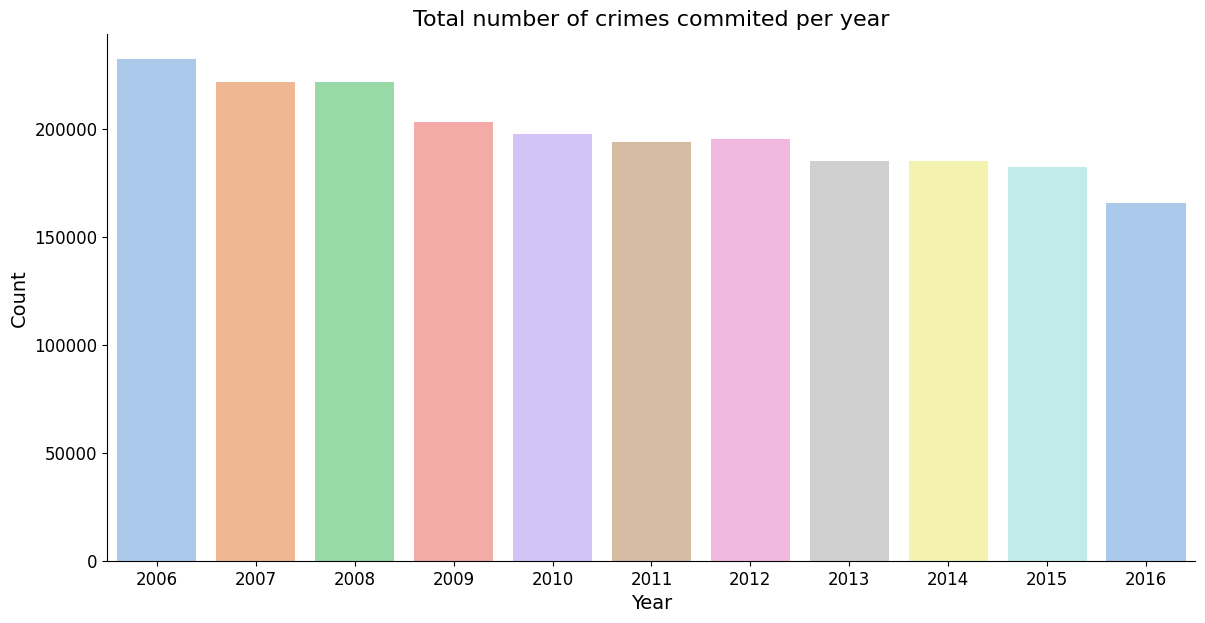

In [9]:
sns.catplot(x='Year_Nr',
            kind='count',
            palette=("pastel"),
            height=6,
            aspect=2,
            data=acpc)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Total number of crimes commited per year", fontsize=16)

<b>Figure 2: Number of crimes commited per Month</b> <br>
Figure 2 shows us the number of crimes happening in each month. Given this figure we can see that a decrease happens towards the end of the year throughout the beginning of the year. This might be due to the outside temperature of these months.


Text(0.5, 1.0, 'Number of Crimes Commited per Month')

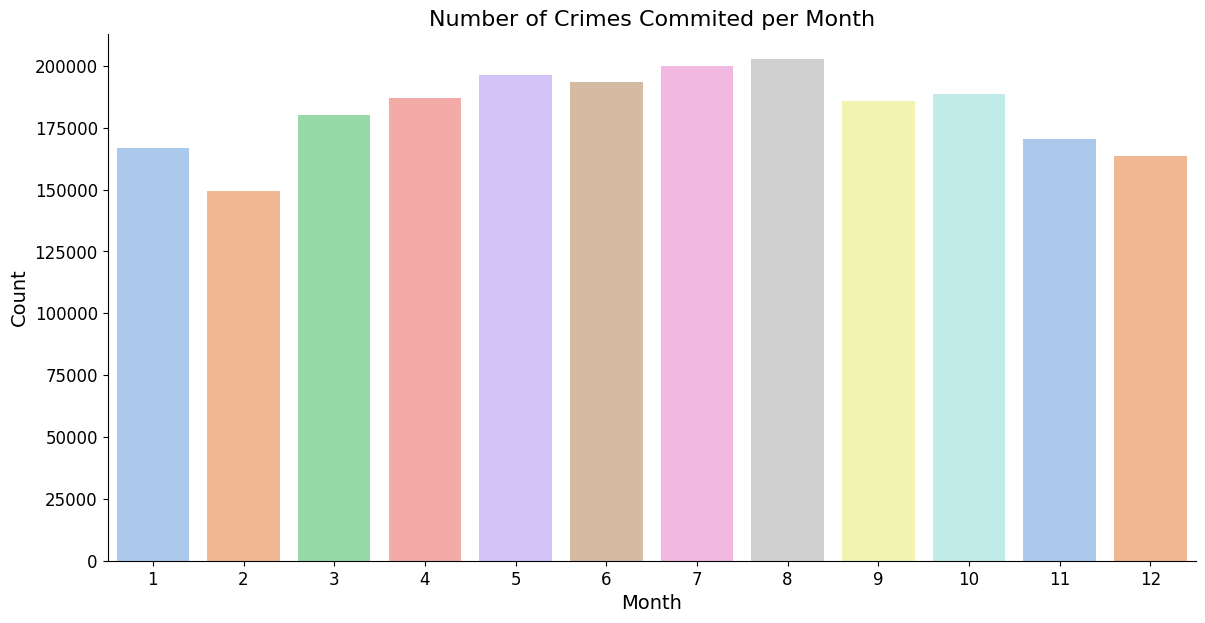

In [10]:
sns.catplot(x='Month_Nr',
           kind='count',
           height=6,
           aspect=2,
           palette=("pastel"),
           data=acpc)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Number of Crimes Commited per Month", fontsize=16)


<b>Figure 3: Number of crimes commited per hour</b><br>
In the third figure we can see that the number of crimes happening reaches a peak at 16:00h and is at its lowest point around 06:00h.
Which is probably due to the sleeping scheduele of people. Furthermore it might be intersting to look at the different types of crime happening around each hour.

Text(0.5, 1.0, 'Number of Crimes Commited per Hour')

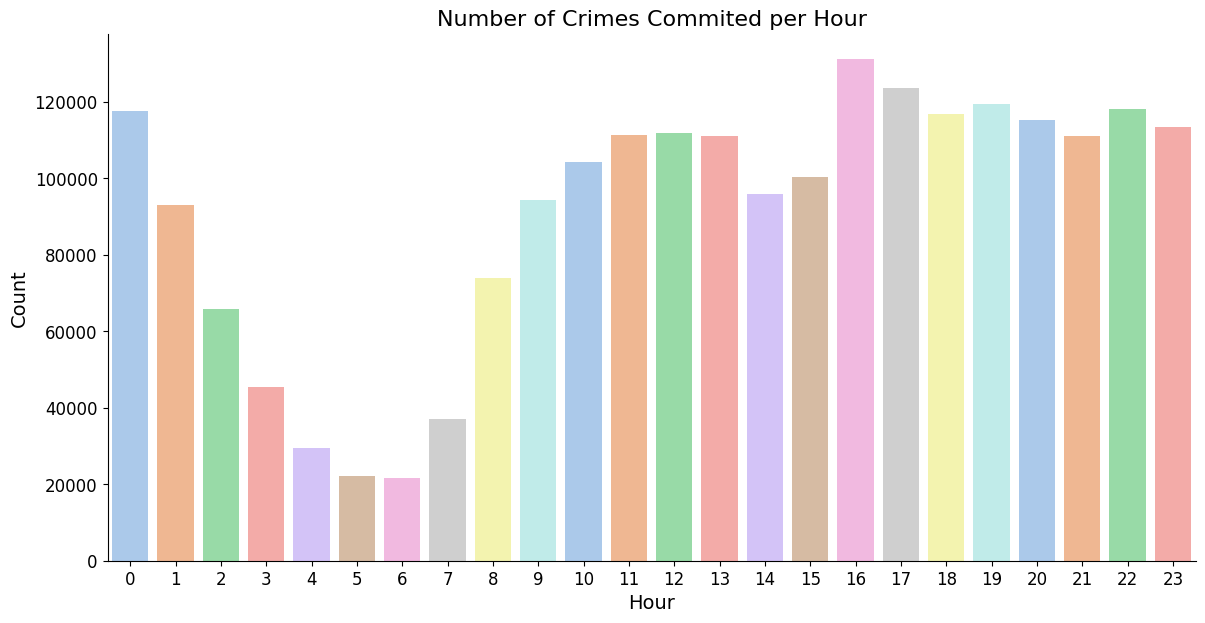

In [11]:
sns.catplot(x='Hour',
           kind='count',
           height=6,
           aspect=2,
           palette=("pastel"),
           data=acpc)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Number of Crimes Commited per Hour", fontsize=16)

<b>Figure 4: Number of Times a Specific Crime was Commited</b><br>
In figure 4, the number of times each crime is commited is visualized. Where the named category Assualts and Theft are crimes that are commited the most within Philadelphia

Text(0.5, 1.0, 'Number of Times a Specific Crime was Commited')

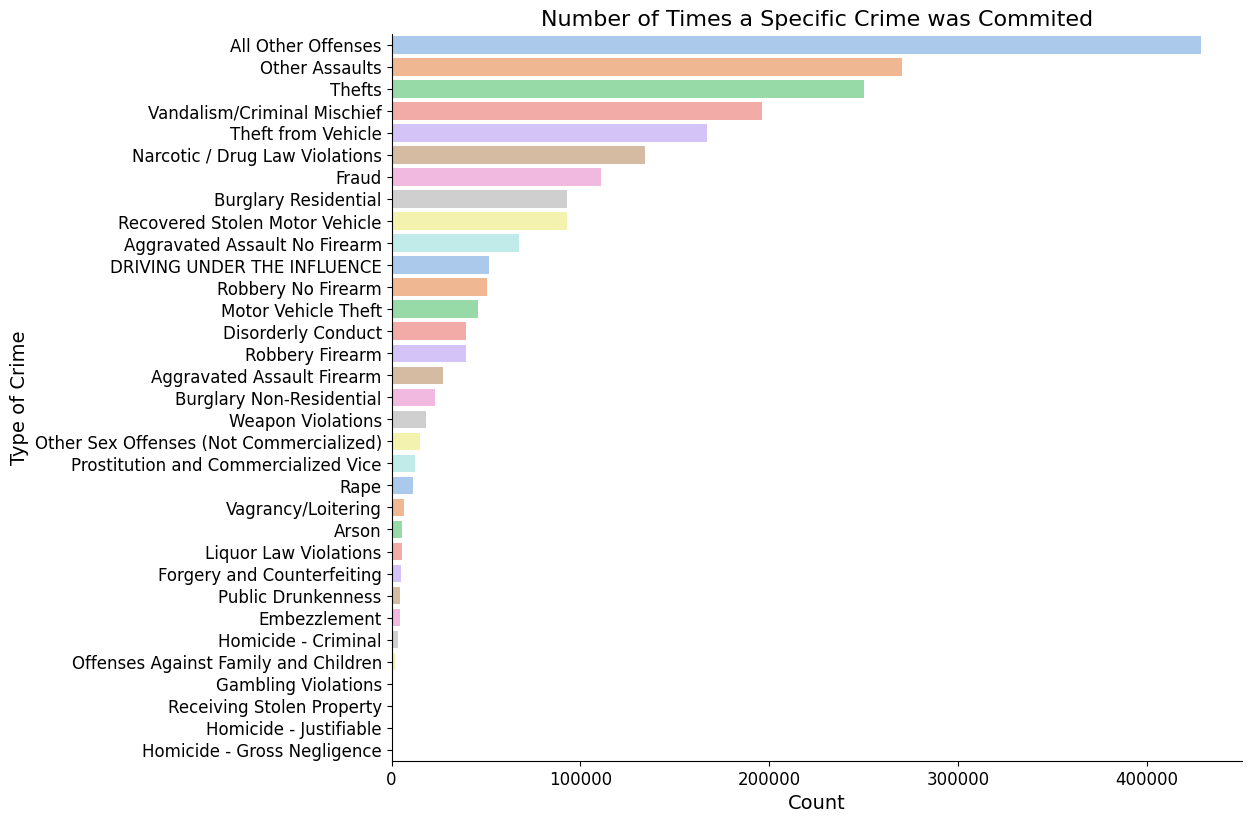

In [12]:
sns.catplot(y='Text_General_Code',
           kind ='count',
           height = 8,
           aspect =1.5, 
           palette=("pastel"),
           order=acpc.Text_General_Code.value_counts().index,
           data=acpc)

plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Type of Crime", fontsize=14)
plt.title("Number of Times a Specific Crime was Commited", fontsize=16)

<b>Figure 5: Number of Times a Specific Crime was Commited</b><br>
In the last figure, figure 5, the number of times a crime is commited in each district is visualized. From this we can see that most crimes happen district 11

Text(0.5, 1.0, 'Number of Crimes Commited per Police District')

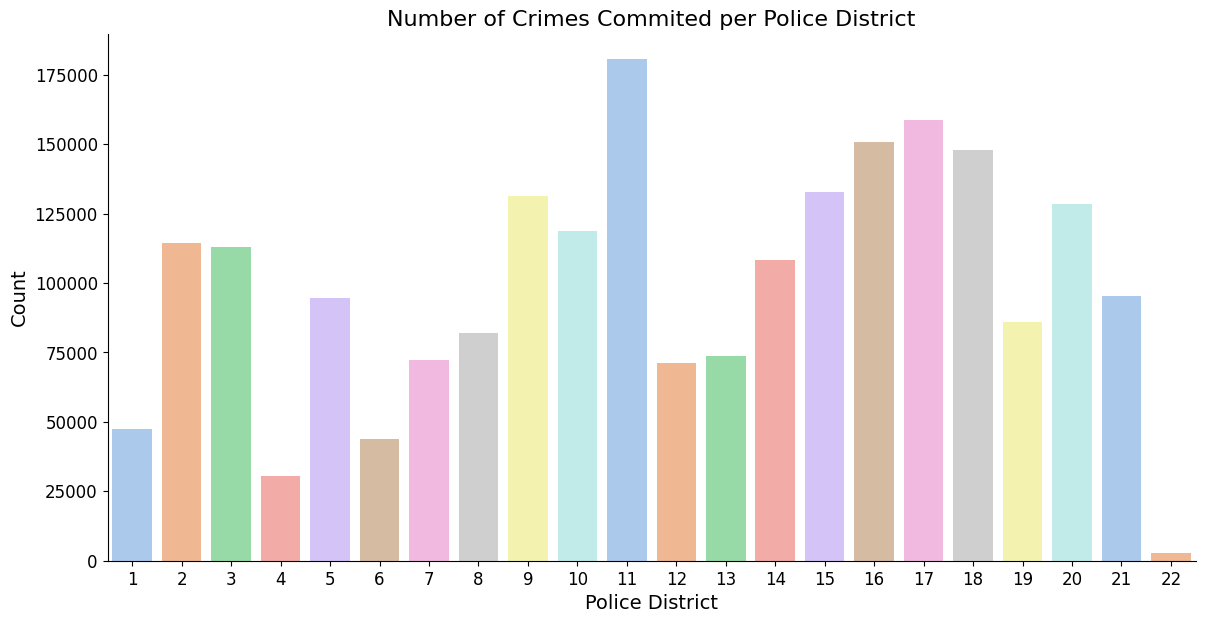

In [13]:
sns.catplot(x='Police_Districts',
           kind='count',
           height=6,
           aspect=2,
           palette=("pastel"),
           data=acpc)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel("Police District", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Number of Crimes Commited per Police District", fontsize=16)

Given the previous image, an indication is given of where each district is placed in the map below.

In [14]:
lon = acpc['Lon']
lat = acpc['Lat']
avgLon = sum(lon)/len(lon)
avgLat = sum(lat)/len(lat)

districts_location = acpc[['Police_Districts', 'Lon', 'Lat']]
districts = districts_location.groupby(['Police_Districts']).mean().reset_index()


crime_map = folium.Map(location=[avgLat, avgLon], 
                       tiles = "Stamen Toner",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = acpc[-25000:]
data_heatmap = data_heatmap[['Lat','Lon']]
data_heatmap = [[row['Lat'],row['Lon']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)
for i in range(len(districts)):
    folium.Marker([districts['Lat'][i], districts['Lon'][i]], popup='District ' + str(districts['Police_Districts'][i])).add_to(crime_map)

# Plot!
crime_map

# Heatmap
The following heatmaps shows the areas in which most crimes, thef crime and violent crime happen

In [15]:
lon = acpc['Lon']
lat = acpc['Lat']
avgLon = sum(lon)/len(lon)
avgLat = sum(lat)/len(lat)

crime_map = folium.Map(location=[avgLat, avgLon], 
                       tiles = "Stamen Toner",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = acpc[-25000:]
data_heatmap = data_heatmap[['Lat','Lon']]
data_heatmap = [[row['Lat'],row['Lon']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)

# Plot!
crime_map

# Voilent Crimes

In [16]:
#showing all types of crimes commited
acpc.Text_General_Code.unique()

# The most dangerous crime (weapon involved) types that can be commited
dangerous = ['Weapon Violations', 'Robbery Firearm', 'Homicide - Criminal', 'Aggravated Assault Firearm', 'Homicide - Gross Negligence', 'Homicide - Justifiable']
# creating a new dataframe with all the dangerous crimes in it
dangerous_data = acpc[acpc['Text_General_Code'].isin(dangerous)]

dangerous_data.head()

,Dc_Dist,Psa,Dispatch_Date_Time,Dispatch_Date,Dispatch_Time,Hour,Dc_Key,Location_Block,UCR_General,Text_General_Code,Police_Districts,Month,Lon,Lat,Year_Nr,Month_Nr,Day_Nr
1325562,18,Q,2006-01-01 00:04:00,2006-01-01,00:04:00,0,200618000007,400 BLOCK S 55TH ST,1500.0,Weapon Violations,14,2006-01,-75.232374,39.953490,2006,1,1
1395649,12,P,2006-01-01 00:05:00,2006-01-01,00:05:00,0,200612000011,1700 BLOCK S 58TH ST,1500.0,Weapon Violations,9,2006-01,-75.230711,39.937644,2006,1,1
1396015,35,R,2006-01-01 00:09:00,2006-01-01,00:09:00,0,200635000008,6600 BLOCK N 18TH ST,1500.0,Weapon Violations,20,2006-01,-75.147835,40.055032,2006,1,1
1351717,39,G,2006-01-01 00:10:00,2006-01-01,00:10:00,0,200639000009,1900 BLOCK W SOMERSET ST,1500.0,Weapon Violations,21,2006-01,-75.162725,39.996597,2006,1,1
1337776,24,C,2006-01-01 00:21:00,2006-01-01,00:21:00,0,200624000010,2800 BLOCK RUTH ST,1500.0,Weapon Violations,17,2006-01,-75.122057,39.990907,2006,1,1


In [17]:
lon = dangerous_data['Lon']
lat = dangerous_data['Lat']
avgLon = sum(lon)/len(lon)
avgLat = sum(lat)/len(lat)

crime_map = folium.Map(location=[avgLat, avgLon], 
                       tiles = "Stamen Toner",
                       zoom_start = 11)

# Add data for heatmp 
data_heatmap = dangerous_data[dangerous_data.Year_Nr == 2016]
data_heatmap = data_heatmap[['Lat','Lon']]
data_heatmap = [[row['Lat'],row['Lon']] for index, row in data_heatmap.iterrows()]

HeatMap(data_heatmap, radius=10).add_to(crime_map)

# Plot!
crime_map

# Theft Crimes

In [18]:
Theft = ['Thefts', 'Theft from Vehicle', 'Motor Vehicle Theft', 'Receiving Stolen Property', 'Recovered Stolen Motor Vehicle']
theft_data = acpc[acpc['Text_General_Code'].isin(Theft)]

In [19]:
lon = theft_data['Lon']
lat = theft_data['Lat']
avgLon = sum(lon)/len(lon)
avgLat = sum(lat)/len(lat)

crime_map = folium.Map(location=[avgLat, avgLon], 
                       tiles = "Stamen Toner",
                       zoom_start = 11)

# Add data for heatmap 
data_heatmap = theft_data[theft_data.Year_Nr == 2016]
data_heatmap = data_heatmap[['Lat','Lon']]
data_heatmap = [[row['Lat'],row['Lon']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)

# Plot!
crime_map